# Exploratory Data Analysis
Spiegare cosa fa questo codice  
spiegare quali siano gli obbiettivi per i quali stiamo preparando i dataset


## Import Packages
* Il pacchetto **numpy** serve a lavorare con valori e array numerici. Performa efficienti conti matematici e statistici.
* Il pacchetto **pandas** serve a manipolare, pulire e gestire dati strutturati attraverso strutture come i DataFrame.
* Il pacchetto **geopandas** è un'estensione del pacchetto *pandas* e serve per gestire dati geospaziali e visualizzarli in mappe.
* Il pacchetto **shapely** serve in collaborazione con geopandas per lavorare sulla geometria dei geodataframes.
* Il pacchetto **json** serve per caricare file con estensione `.json` 
* Il pacchetto **matplotlib** viene utilizzato per eseguire plot di grafici e lavorare su di essi.
* Il pacchetto **plotly** viene utilizzato per eseguire plot di grafici e lavorare su di essi. È utile, come alternativa a **matplotlib**, per visualizzazioni dinamiche, dove si può fare zoom, passare con il mouse sui punti, ecc.


In [88]:
import numpy as np

import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon
import json

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import plotly.graph_objects as go

## Importa Data

Il primo DataFrame contiene i dati sui consumi delle linee elettriche di tutto il Trentino.  
Per ogni linea elettrica viene fornito il dato di consumo ogni 10 minuti per l'intero mese.  
I dati sono per il mese di Novembre 2013 (il processo verrà ripetuto per il mese di Dicembre 2013).


Il secondo DataFrame contiene i dati riguardanti le ubicazioni e linee elettriche presenti in ogni zona del Trentino.  
Per ogni zona del Trentino (identificata da *SQUAREID*) vengono associate le linee elettriche da lì passanti (*LINESET*) e per ogni combinazione di zona e linea elettrica viene associato il numero di ubicazioni presenti (*NR_UBI*)



In [89]:
file_path_proc = "C:/Users/ADMIN/Desktop/Data Science/Lavandini/data/processed/"
file_path_raw = "C:/Users/ADMIN/Desktop/Data Science/Lavandini/data/data_trentino/raw/"
file_path_ext = "C:/Users/ADMIN/Desktop/Data Science/Lavandini/data/data_trentino/external/"
set_nov_df = pd.read_csv(file_path_proc + "SET-nov-2013.csv")
set_dec_df = pd.read_csv(file_path_proc + "SET-dec-2013.csv")
lin_df = pd.read_csv(file_path_proc + "line.csv")
set_nov_df[:5]

LINESET              DATE      POWER
0  DG1000420  01/11/2013 00:00  37.439999
1  DG1000420  01/11/2013 00:10  37.439999
2  DG1000420  01/11/2013 00:20  36.000000
3  DG1000420  01/11/2013 00:30  35.279999
4  DG1000420  01/11/2013 00:40  35.279999

In [90]:
lin_df[:5]

SQUAREID    LINESET  NR_UBI
0       155  DG1031221       4
1       272  DG1031221      72
2       273  DG1031221      21
3       276  DG1003117      34
4       277  DG1003117       3

## Trasformazione colonna *DATE* e uniamo i set di novembre e di dicembre
Uniamo i due dataset

In [91]:
set_df = pd.concat([set_nov_df,set_dec_df], ignore_index=True)
set_df = set_df[["LINESET",	"DATE",	"POWER"]]

del set_nov_df, set_dec_df

set_df

LINESET              DATE      POWER
0        DG1000420  01/11/2013 00:00  37.439999
1        DG1000420  01/11/2013 00:10  37.439999
2        DG1000420  01/11/2013 00:20  36.000000
3        DG1000420  01/11/2013 00:30  35.279999
4        DG1000420  01/11/2013 00:40  35.279999
...            ...               ...        ...
1615889  DG1056626  31/12/2013 23:10  79.574997
1615890  DG1056626  31/12/2013 23:20  78.625000
1615891  DG1056626  31/12/2013 23:30  77.025002
1615892  DG1056626  31/12/2013 23:40  76.125000
1615893  DG1056626  31/12/2013 23:50  75.775002

[1615894 rows x 3 columns]


Trasformiamo la colonna *DATE* in tre colonne separate che indicano il giorno (*DAY*), i minuti (*MIN*) e il giorno della settimana (*WEEK_DAY*).

In [92]:
set_df["DATE"] = pd.to_datetime(set_df["DATE"], format="%d/%m/%Y %H:%M", dayfirst=True)
set_df["MONTH"] = pd.to_datetime(set_df["DATE"]).dt.month
set_df["DAY"] = pd.to_datetime(set_df["DATE"]).dt.day
set_df["WEEK_DAY"] = pd.to_datetime(set_df["DATE"]).dt.day_of_week
set_df["MINUTE"] = pd.to_datetime(set_df["DATE"]).dt.hour * 60 + pd.to_datetime(set_df["DATE"]).dt.minute
del set_df["DATE"]
set_df[:5]

LINESET      POWER  MONTH  DAY  WEEK_DAY  MINUTE
0  DG1000420  37.439999     11    1         4       0
1  DG1000420  37.439999     11    1         4      10
2  DG1000420  36.000000     11    1         4      20
3  DG1000420  35.279999     11    1         4      30
4  DG1000420  35.279999     11    1         4      40

## Trasformazione corrente in potenza media
Trasformiamo la corrente erogata, in potenza media misurata in KWh.  
Alle ubicazioni civili viene associata una tensione trifase: 240V (RMS).  
Dunque: $KWh = kV * I * 1h = 240V/1000 * I * 3600s = 240kV*3.6s * I = 864 KV*s * I$  
Definisco quindi la costante di conversione `conv_to_KWh` := 864 KV*s e converto la colonna *POWER* in KWh.


In [93]:
conv_to_KWh = 240/1000*3600
set_df["POWER"] *= conv_to_KWh
set_df[:5]

LINESET         POWER  MONTH  DAY  WEEK_DAY  MINUTE
0  DG1000420  32348.159136     11    1         4       0
1  DG1000420  32348.159136     11    1         4      10
2  DG1000420  31104.000000     11    1         4      20
3  DG1000420  30481.919136     11    1         4      30
4  DG1000420  30481.919136     11    1         4      40

## Consumo mensile per zona
Quello che vogliamo vedere come prima cosa è visualizzare qual'è il consumo medio mensile per ogni zona.  

Quello che faremo sarà: 
* creare un dataframe `mean_df` a partire da `set_df` mediando i valori di potenza su tutto il mese
* unire `mean_df` e `lin_df` in modo da associare anche ad ogni zona la potenza
* eseguire una media pesata della potenza sul numero di ubicazioni
* creare un geodataframe con le informazioni ottenute, unite al file `.geojson` contenente le informazioni geografiche delle zone del trentino
* creare un plot geografico dei consumi medi mensili
* unire il plot con la cartina geografica con le provincie del Trentino


In [94]:
# eseguiamo la media giornaliera della potenza 
mean_df = set_df.groupby("LINESET")["POWER"].sum()/set_df["DAY"].iloc[-1]

# uniamo il dataframe mediato con lin_df preservando le colonne LINESET, POWER, SQUAREID e NR_UBI
mean_df = pd.merge(mean_df,lin_df, on="LINESET", how="right")

# aggiungiamo colonna con il numero totale di ubicazioni per squareid
mean_df["TOT_UBI"] = lin_df.groupby("SQUAREID")["NR_UBI"].transform("sum")

# eseguiamo la media pesata della potenza sul numero di ubicazioni
mean_df["W_POWER"] = mean_df["POWER"] * mean_df["NR_UBI"] / mean_df["TOT_UBI"]
mean_df[18:25]

LINESET         POWER  SQUAREID  NR_UBI  TOT_UBI       W_POWER
18  DG1031221  1.077528e+07       742      32       32  1.077528e+07
19  DG1003117  1.545608e+07       743      10       84  1.840009e+06
20  DG1031221  1.077528e+07       743      74       84  9.492507e+06
21  DG1003117  1.545608e+07       752       5        5  1.545608e+07
22  DG1031220  8.444821e+06       854      20       20  8.444821e+06
23  DG1031221  1.077528e+07       857       8        8  1.077528e+07
24  DG1031221  1.077528e+07       858      80       80  1.077528e+07

In [95]:
# creiamo il geodataframe di mean_df raggruppando per square id e sommando i vari contributi pesati di corrente
mean_gdf = gp.GeoDataFrame(mean_df.groupby("SQUAREID")["W_POWER"].sum())
mean_gdf[18:25]

W_POWER
SQUAREID              
742       1.077528e+07
743       1.133252e+07
752       1.545608e+07
854       8.444821e+06
857       1.077528e+07
858       1.077528e+07
859       1.077528e+07

Importiamo i dati riguardanti le posizioni dei quadratini sulla griglia del trentino

In [96]:
tn_grid_gdf = gp.read_file(file_path_raw + "trentino-grid.geojson")
tn_grid_gdf[:5]

cellId                                           geometry
0      38  POLYGON ((10.91462 45.68201, 10.92746 45.68179...
1      39  POLYGON ((10.92746 45.68179, 10.94029 45.68157...
2      40  POLYGON ((10.94029 45.68157, 10.95312 45.68136...
3     154  POLYGON ((10.90209 45.69122, 10.91493 45.691, ...
4     155  POLYGON ((10.91493 45.691, 10.92777 45.69079, ...

Uniamo i geodataframe `tn_grid_gdf` e `mean_gdf`

In [97]:
grid_mean_gdf = pd.merge(tn_grid_gdf,mean_gdf,left_on="cellId",right_on="SQUAREID").rename(columns={"cellId":"SQUAREID"})
del(mean_gdf)
# controlliamo anche che non siano presenti dei Not a Number
print(grid_mean_gdf.isna().sum())
grid_mean_gdf[3:8]

SQUAREID    0
geometry    0
W_POWER     0
dtype: int64


SQUAREID                                           geometry       W_POWER
3       276  POLYGON ((10.96659 45.69913, 10.97943 45.6989,...  1.545608e+07
4       277  POLYGON ((10.97943 45.6989, 10.99226 45.69868,...  1.545608e+07
5       389  POLYGON ((10.91554 45.70899, 10.92838 45.70878...  1.077528e+07
6       390  POLYGON ((10.92838 45.70878, 10.94122 45.70856...  1.077528e+07
7       393  POLYGON ((10.9669 45.70812, 10.97974 45.7079, ...  1.545608e+07

Facciamo un primo plot per capire se procede tutto come previsto

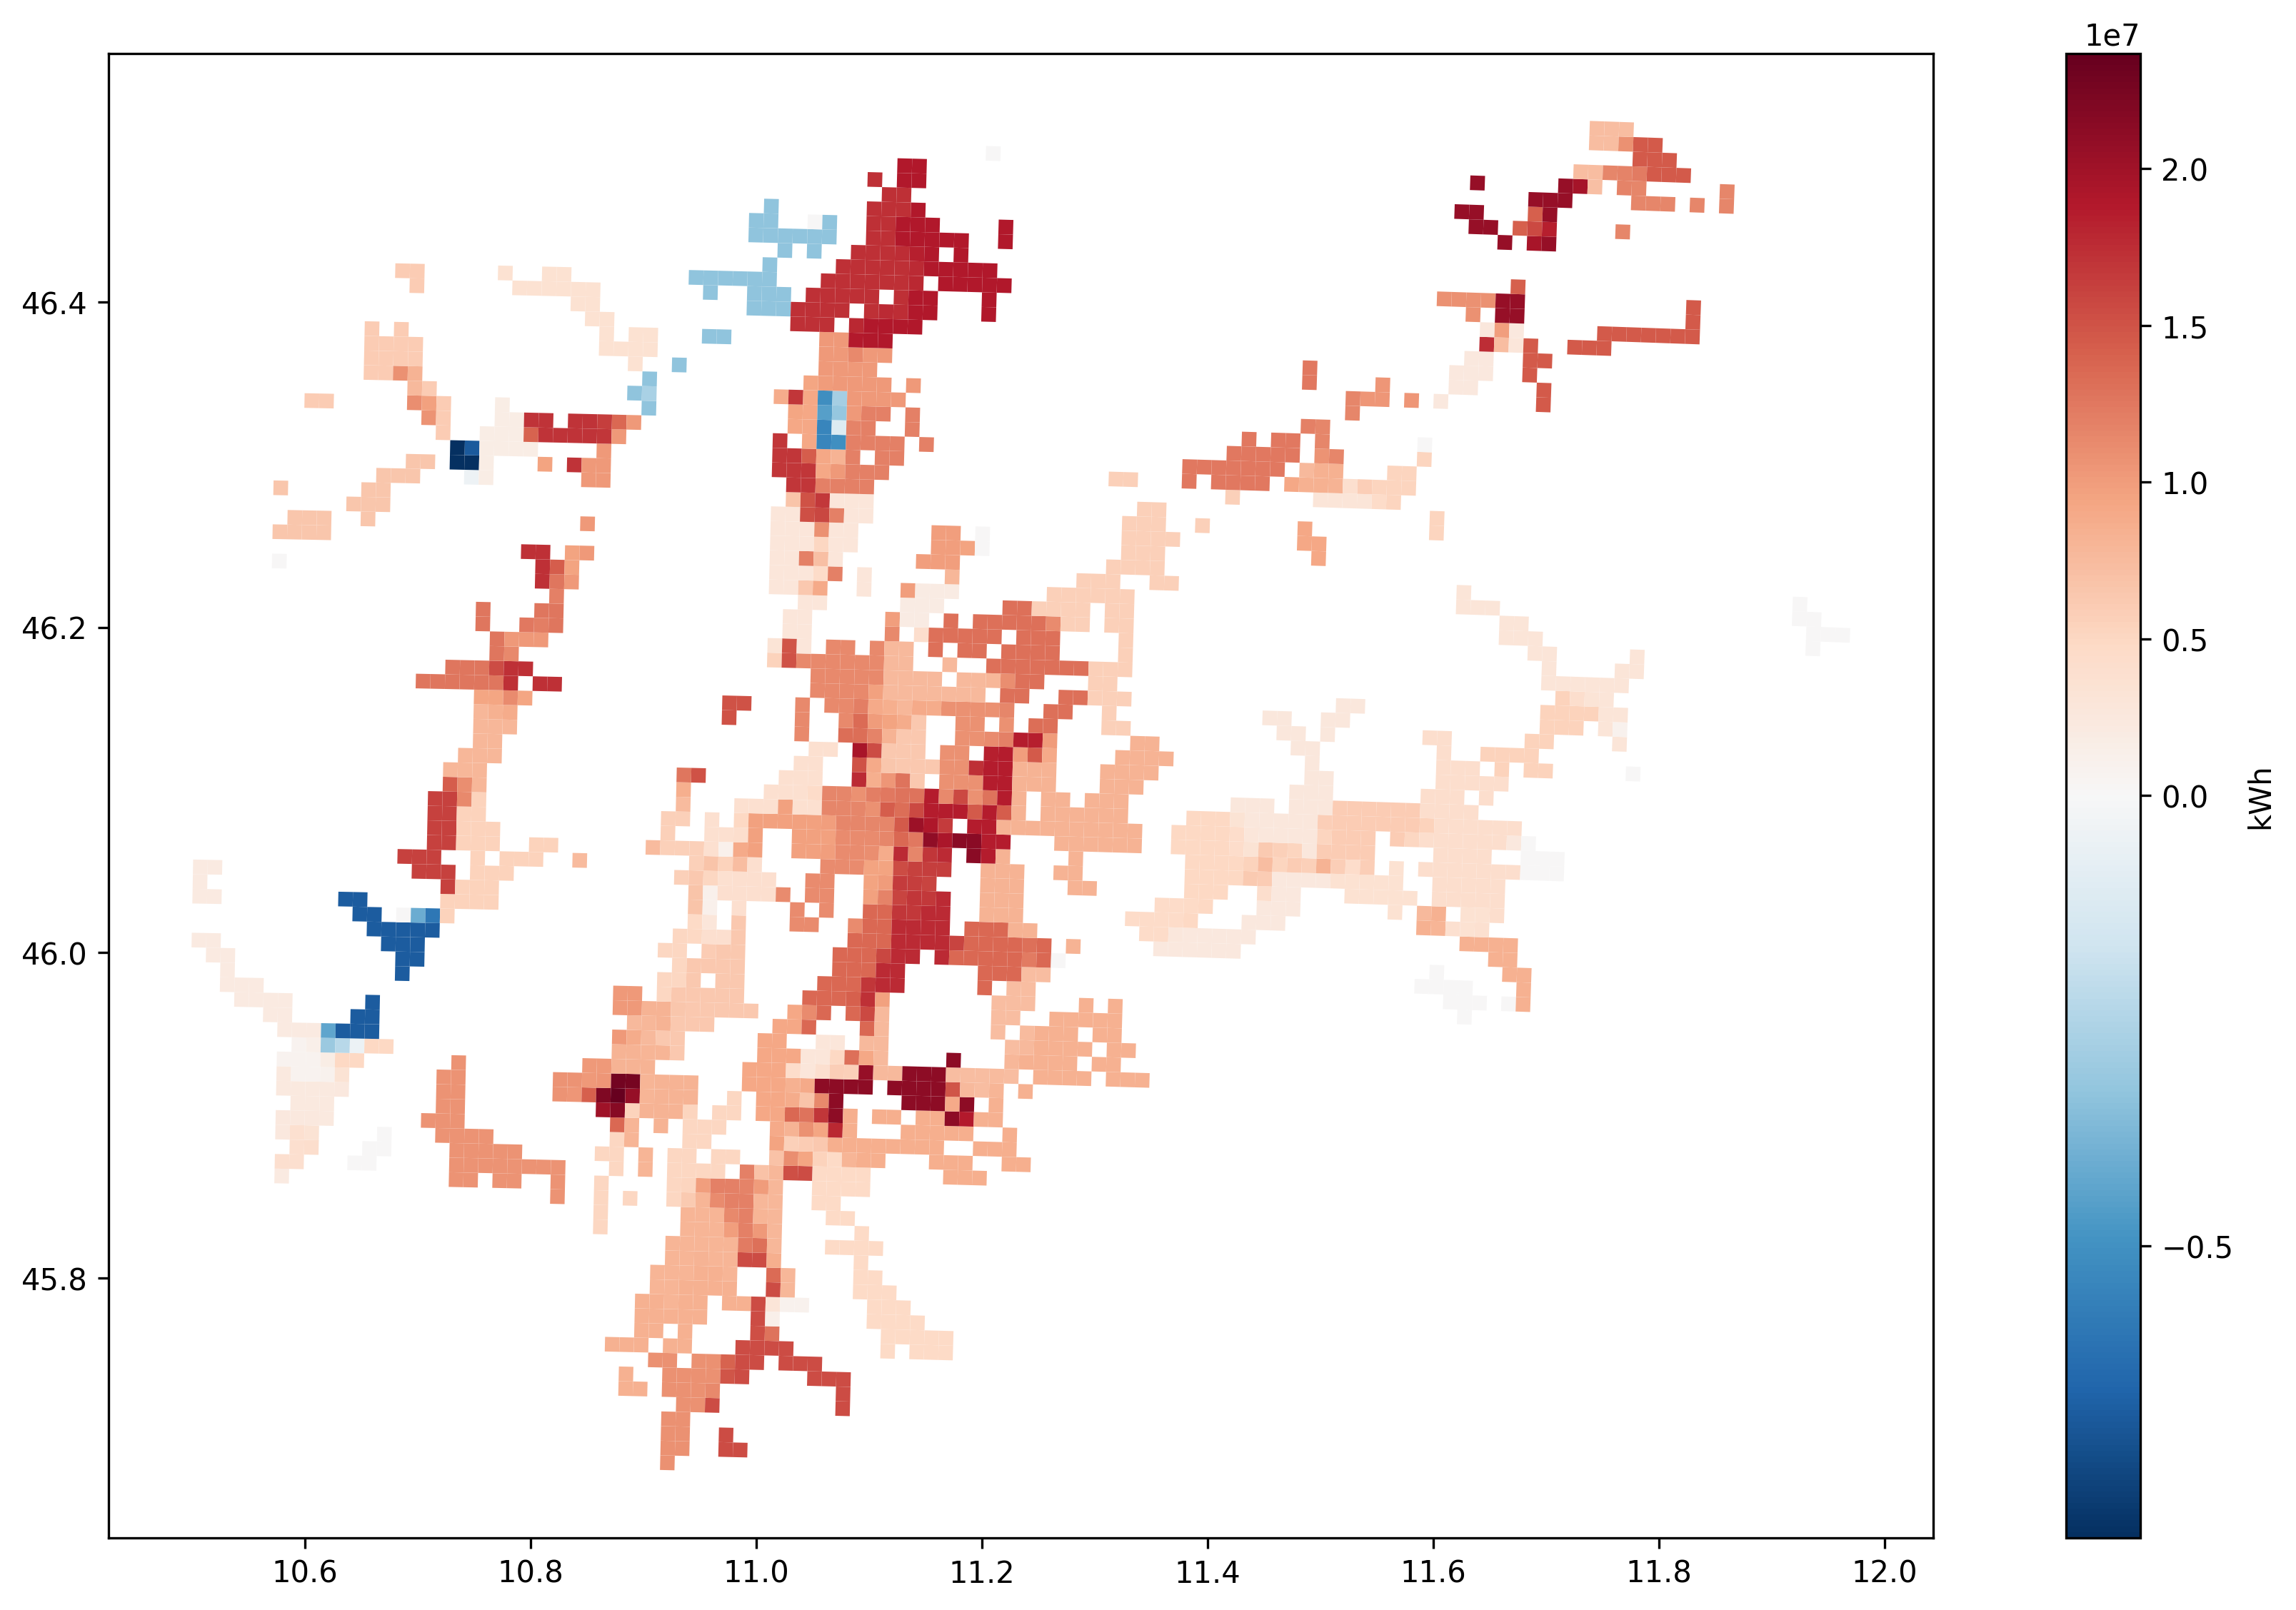

In [98]:
# creiamo figura e assi
fig, ax = plt.subplots(figsize=(16, 9), dpi=300)  # dpi aumentato per maggiore risoluzione

# creiamo la color shape
norm = TwoSlopeNorm(vmin=grid_mean_gdf['W_POWER'].min(), 
                    vcenter=0, 
                    vmax=grid_mean_gdf['W_POWER'].max())

# plotta la mappa
grid_mean_gdf.plot(column='W_POWER', ax=ax, legend=True, legend_kwds={'label': "kWh", 'orientation': "vertical"},
                   cmap='RdBu_r', norm=norm)
plt.show()

Si nota subito che sono presenti della zone in cui il consumo medio giornaliero assume valori negativi. Una prima ipotesi intuitiva per giustificare il fatto, potrebbe essere dovuta alla presenza di centrali elettriche; cercheremo di capire in seguito se si tratta di un errore di dati oppure di motivo vero.  
Notiamo inoltre che ci sono delle zone a consumi maggiori, vedremo successivamente esattamente quali sono queste zone.

Intanto continuiamo plottando anche la mappa del trentino e le regioni amministrative:  
Per prima cosa importiamo i dati delle regioni amministrative e creiamo un geodataframe

In [99]:
# Leggiamo il file .shp in un GeoDataFrame
adm_reg_gdf = gp.read_file(file_path_ext + 'gdf_com/gdf_com.shp')

# cambiamo il Coordinate Reference System in modo da 
crs = 'EPSG:4326'
adm_reg_gdf = adm_reg_gdf.to_crs(crs)

# selezioniamo solo la provinzia del trentino (codice ISTAT 022)
adm_reg_gdf = adm_reg_gdf[adm_reg_gdf["COD_PROV"]==22]

adm_reg_gdf[:5]

COD_RIP  COD_REG  COD_PROV  PRO_COM PRO_COM_T          COMUNE COMUNE_A  \
1238        2        4        22    22189    022189  Telve di Sopra     None   
1239        2        4        22    22190    022190           Tenna     None   
1240        2        4        22    22191    022191           Tenno     None   
1259        2        4        22    22172    022172       Segonzano     None   
1271        2        4        22    22192    022192         Terlago     None   

      CC_P    Shape_Leng    Shape_Area  \
1238     0  30564.563487  1.771618e+07   
1239     0   8647.977750  3.114708e+06   
1240     0  24637.459823  2.830107e+07   
1259     0  21551.885198  2.071212e+07   
1271     0  31496.815914  3.704635e+07   

                                               geometry  
1238  POLYGON ((11.42124 46.1374, 11.42159 46.1371, ...  
1239  POLYGON ((11.2596 46.03201, 11.26001 46.03199,...  
1240  POLYGON ((10.77604 45.96234, 10.77729 45.96203...  
1259  POLYGON ((11.30612 46.22113, 11.30628 46.22111...  
1271  POLYGON ((11.06203 46.15178, 11.06274 46.15126...

Ora creiamo un plot sovrapposto alla mappa precedente

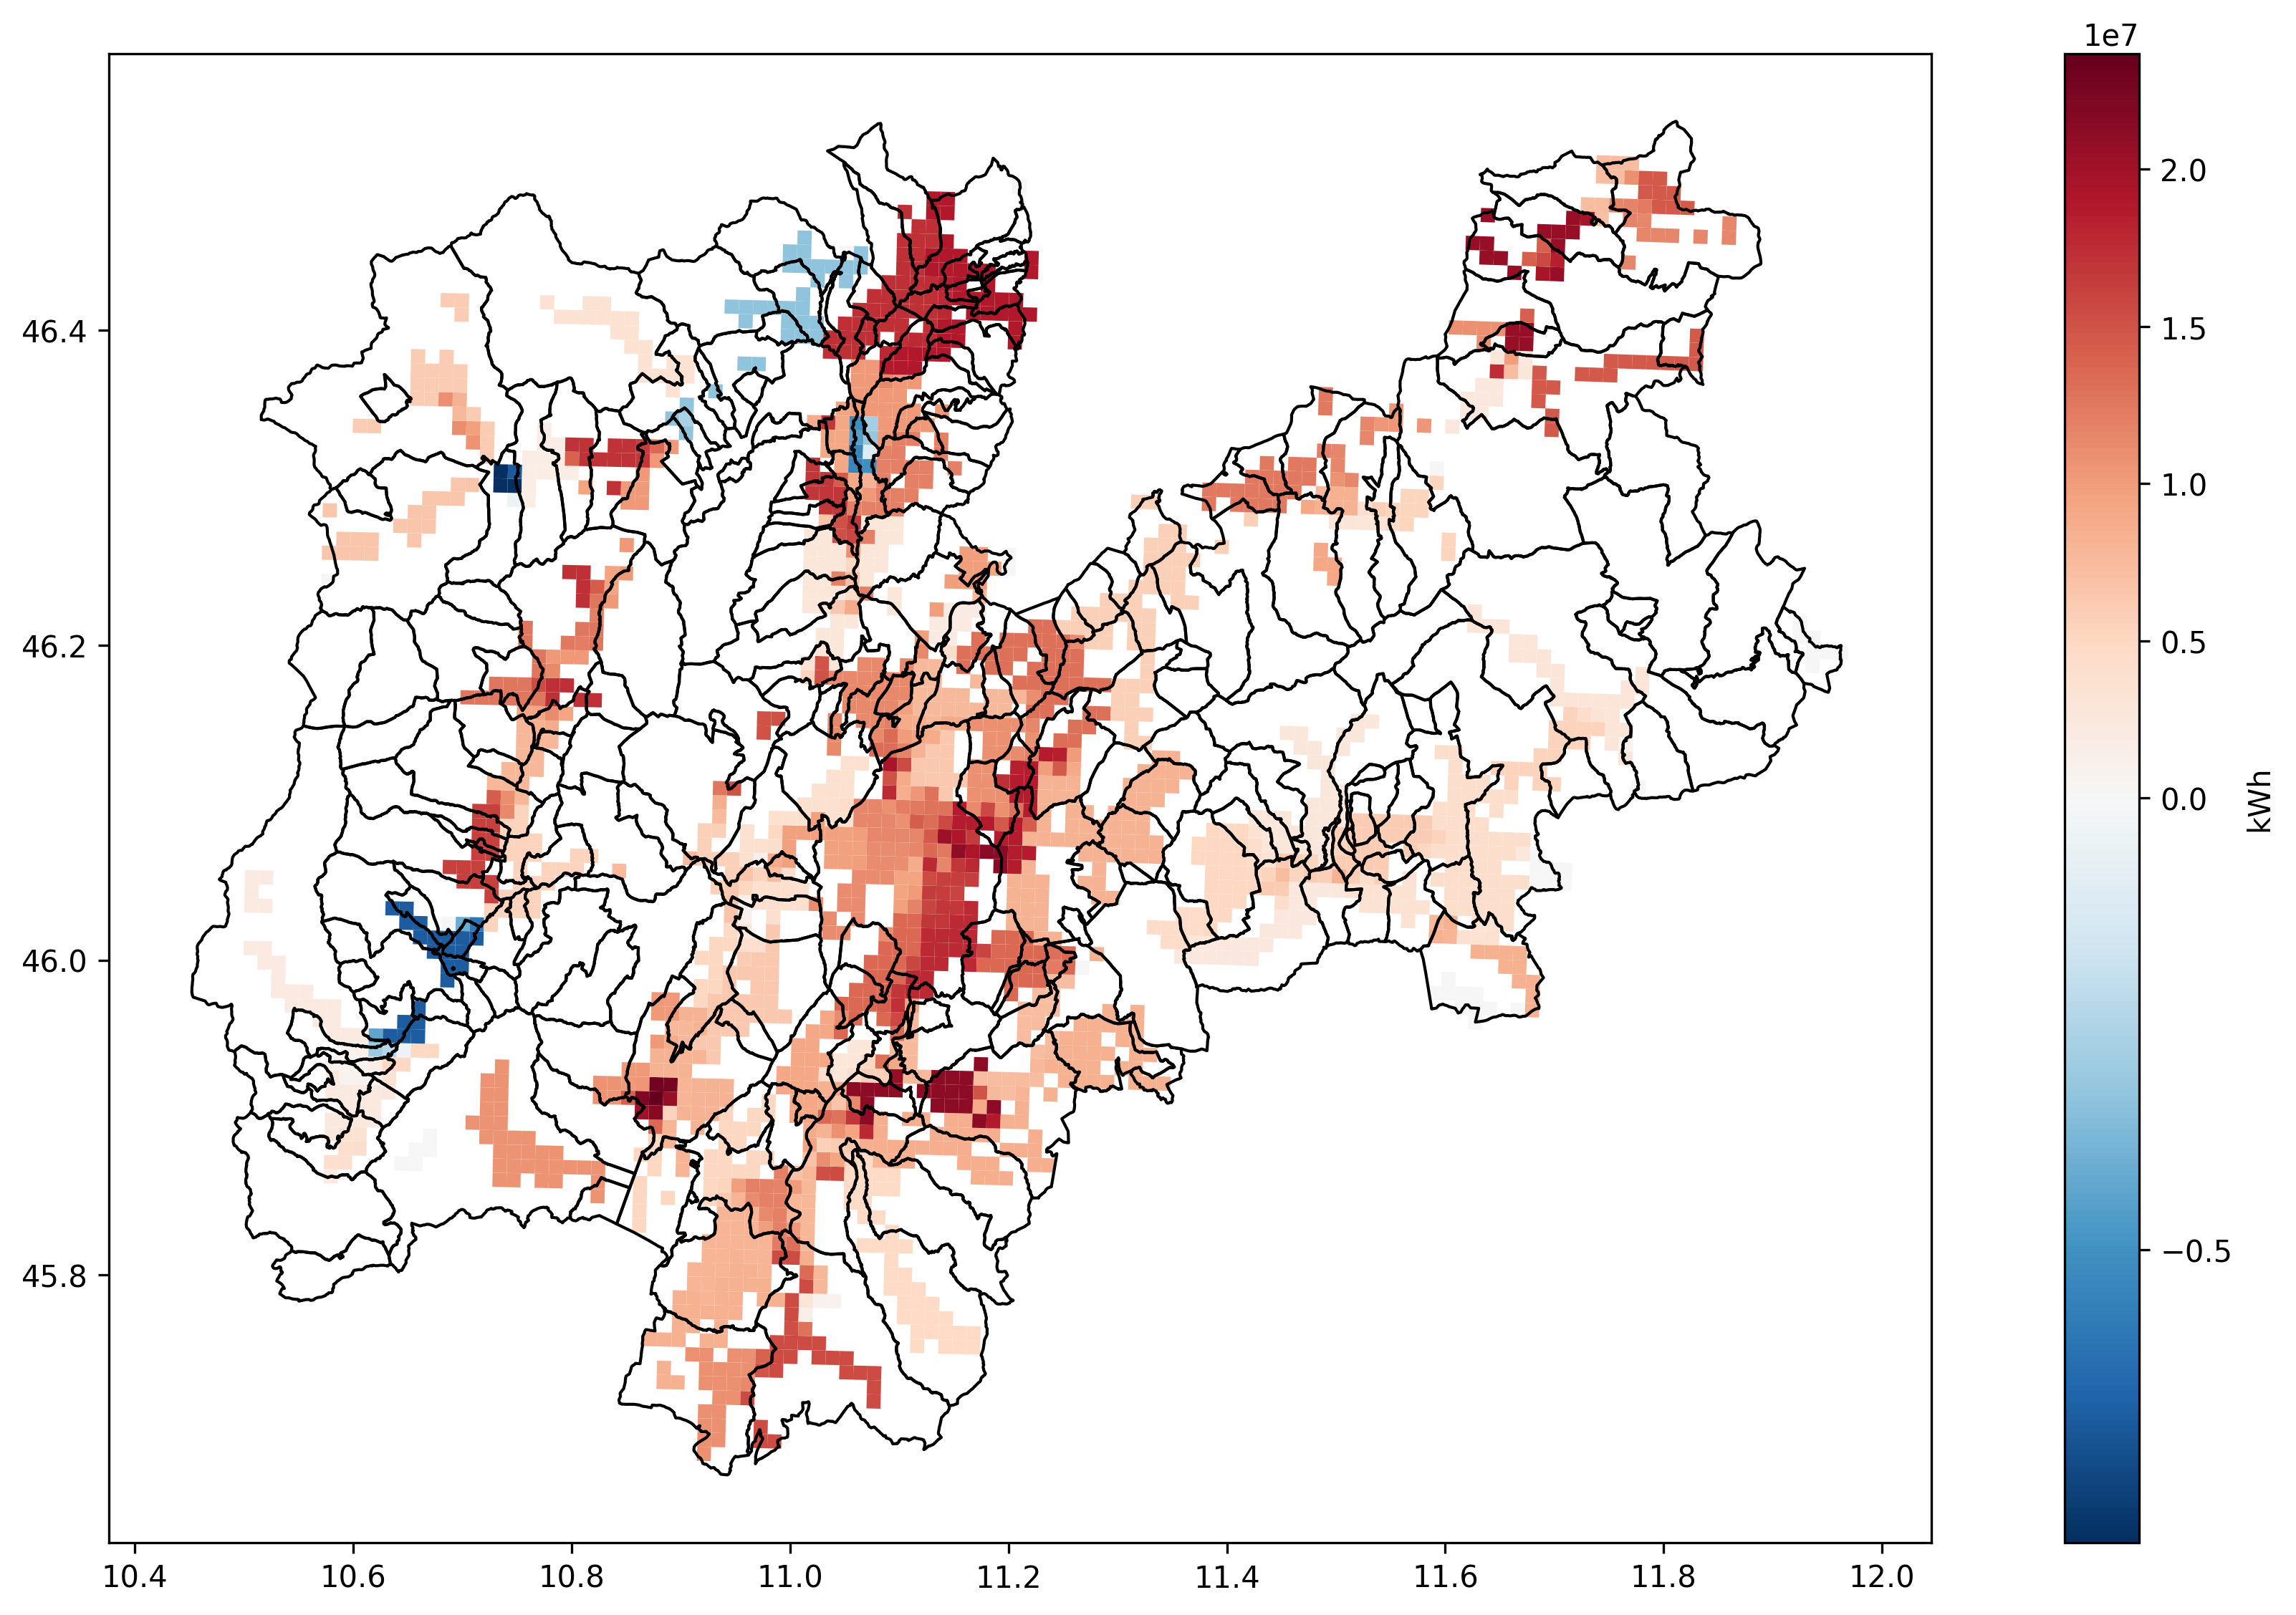

In [100]:
# creiamo la figura e assi
fig, ax = plt.subplots(figsize=(16, 9), dpi=300)  # dpi aumentato per maggiore risoluzione

# plottiamo la mappa con la potenza media
grid_mean_gdf.plot(column='W_POWER', ax=ax, cmap='RdBu_r', norm=norm, 
                   legend=True, legend_kwds={'label': "kWh", 'orientation': "vertical"})

# plottiamo la mappa dei comuni del trentino
adm_reg_gdf.plot(ax=ax, color='none', edgecolor='black')


plt.show()


### Conclusioni consumi mensili per zona 

---

## Variazioni orarie e giornaliere dei consumi
Quello che andiamo ad analizzare ora sarà di vedere quali sono le zone a più alta variazione dei consumi durante l'arco della giornata e del mese.

Come prima cosa torniamo a lavorare sul dataframe `set_df` e creiamo due nuovi dataframes contenenti le variazioni della potenza nel corso della giornata (`var_day_df`) e nel corso del mese (`var_mon_df`)

In [101]:
var_day_df = set_df.copy()

# eseguiamo la somma sui 60 minuti di ogni ora e la media del valore POWER per ogni ora rispetto a tutti i giorni
var_day_df = var_day_df.groupby(['LINESET', 'MINUTE'])['POWER'].mean().reset_index()

# eseguiamo la differenza tra le varie righe in valore assoluto
var_day_df['VAR_POW'] = abs(var_day_df.groupby('LINESET')['POWER'].diff()) # magari fare in modo che avvenga la sottrazione tra 1440 e 0

# togliamo i not a number e riordiniamo le colonne
var_day_df = var_day_df.dropna(subset=['VAR_POW'])
var_day_df = var_day_df[['LINESET', 'POWER', 'VAR_POW', 'MINUTE']]
var_day_df[140:150]

LINESET         POWER     VAR_POW  MINUTE
141  DG1000420  41302.031158  790.347470    1410
142  DG1000420  40532.079782  769.951376    1420
143  DG1000420  39751.930189  780.149593    1430
145  DG1000421  23827.702601  232.005274      10
146  DG1000421  23664.534105  163.168496      20
147  DG1000421  23501.365552  163.168553      30
148  DG1000421  23419.781261   81.584291      40
149  DG1000421  23519.212166   99.430905      50
150  DG1000421  23215.820676  303.391490      60
151  DG1000421  23167.380049   48.440627      70

In [113]:
var_mon_df = set_df.copy()

# eseguiamo la somma della potenza sulle 24 ore di ogni giorno ed eseguiamo la differenza tra le varie righe
var_mon_df = var_mon_df.groupby(['LINESET', 'DAY', 'WEEK_DAY','MONTH'])['POWER'].sum().reset_index()
var_mon_df['VAR_POW'] = var_mon_df.groupby('LINESET')['POWER'].diff()
var_mon_df["VAR_POW"] = abs(var_mon_df["VAR_POW"])

# togliamo i not a number e riordiniamo le colonne
var_mon_df = var_mon_df.dropna(subset=['VAR_POW'])
var_mon_df = var_mon_df[['LINESET', 'POWER', 'VAR_POW', 'DAY', 'WEEK_DAY','MONTH']]

var_mon_df[140:150]

LINESET         POWER       VAR_POW  DAY  WEEK_DAY  MONTH
143  DG1000422  4.749270e+06  8.592479e+05   11         2     12
144  DG1000422  3.493135e+06  1.256135e+06   12         1     11
145  DG1000422  5.007899e+06  1.514765e+06   12         3     12
146  DG1000422  3.487225e+06  1.520674e+06   13         2     11
147  DG1000422  5.192346e+06  1.705121e+06   13         4     12
148  DG1000422  3.606353e+06  1.585993e+06   14         3     11
149  DG1000422  5.413029e+06  1.806676e+06   14         5     12
150  DG1000422  3.672605e+06  1.740424e+06   15         4     11
151  DG1000422  5.340557e+06  1.667952e+06   15         6     12
152  DG1000422  5.698875e+06  3.583180e+05   16         0     12

Ora plottiamo i dati riguardanti le variazioni medie durante l'arco della giornata

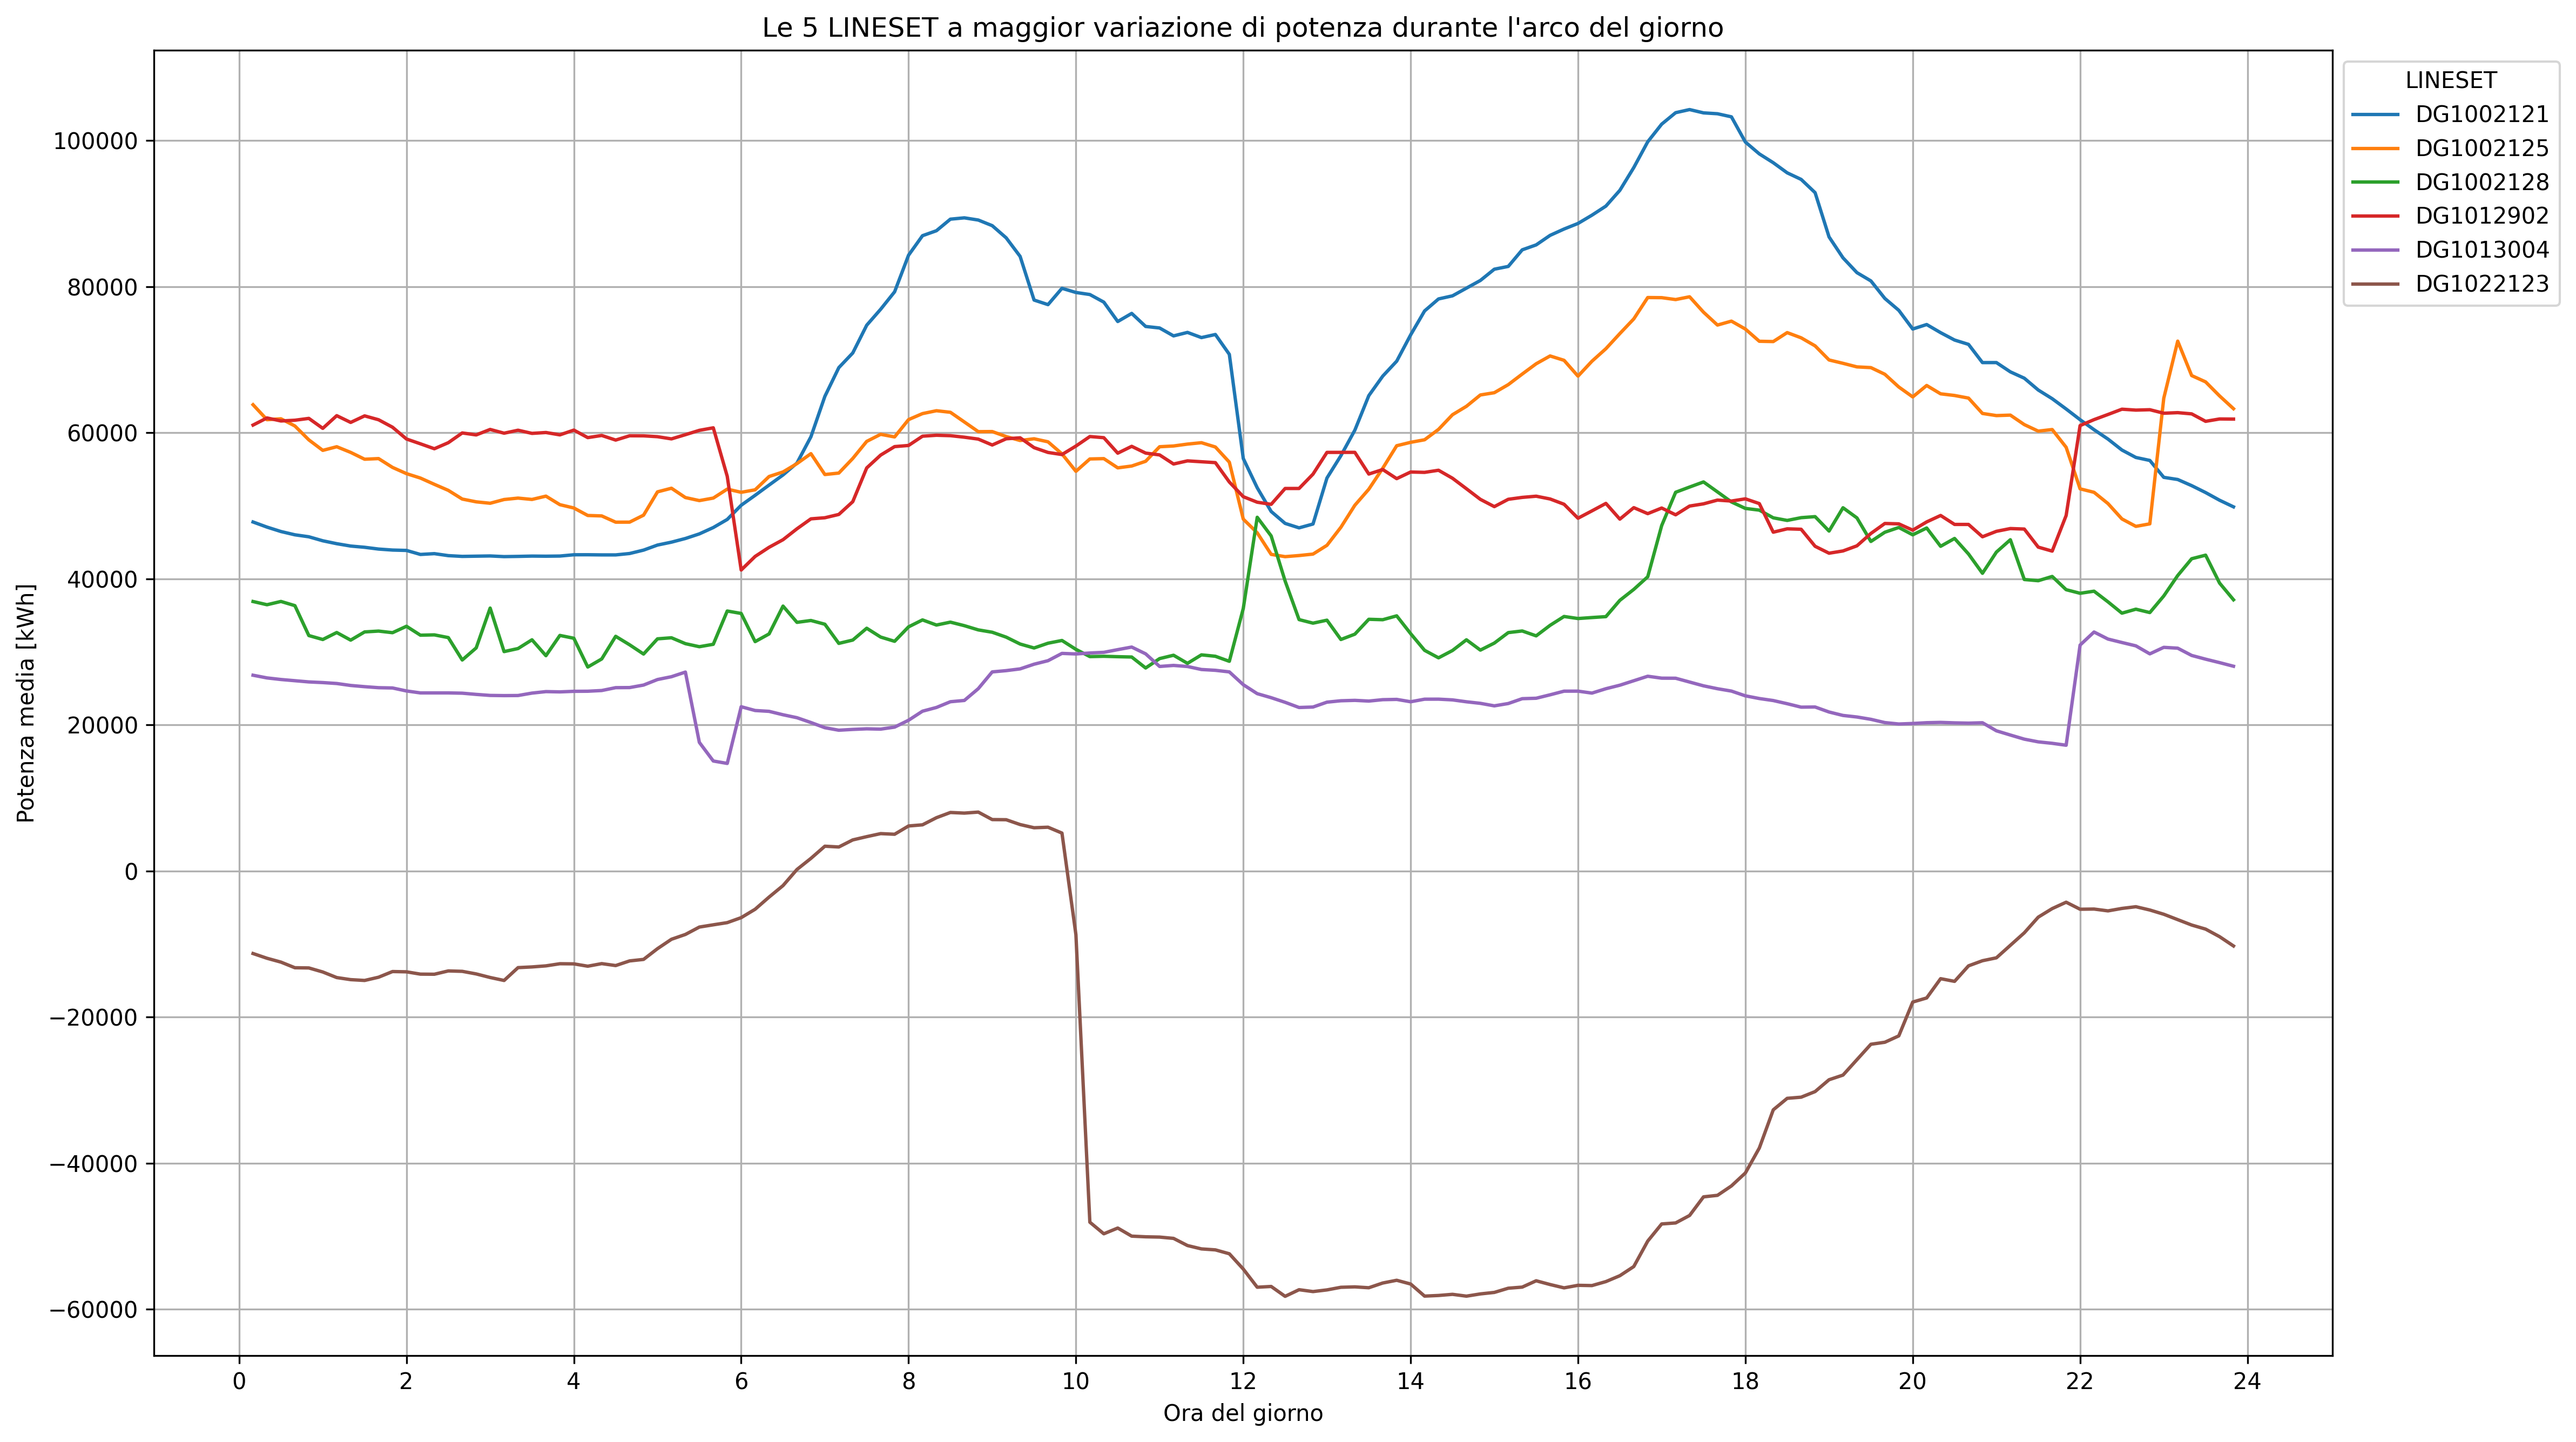

In [114]:
# creiamo la colonna ore
var_day_df['HOUR'] = var_day_df['MINUTE'] / 60

# Creiamo la figura
fig_day = plt.figure(figsize=(16, 9),dpi=300)

# Loop attraverso i LINESET dove la variazione di potenza supera i 12000 kWh (così preso in modo da avere solo le 5 linee a variazione magiore)
# e plottiamo POWER in funzione di HOUR
for lineset in var_day_df['LINESET'][var_day_df['VAR_POW']>12e3].unique():
    subset = var_day_df[var_day_df['LINESET'] == lineset]
    plt.plot(subset['HOUR'], subset['POWER'], label=lineset)

# aggiungo le label e il titolo
plt.xlabel('Ora del giorno')
plt.ylabel('Potenza media [kWh]')
plt.title('Le 5 LINESET a maggior variazione di potenza durante l\'arco del giorno')

# cambio xticks in modo da mostrare una tacca ogni 2 ore e aggiungo griglia
plt.xticks(np.arange(0,25,step=2))
plt.grid()

# legenda per le diverse LINESET
plt.legend(title='LINESET', bbox_to_anchor=(1, 1), loc='upper left')

# mostriamo il grafico
plt.tight_layout()
plt.show()


Ora creiamo, come fatto in precendenza, la mappa con le variazioni di potenza evidenziando quelle a maggior variazione.

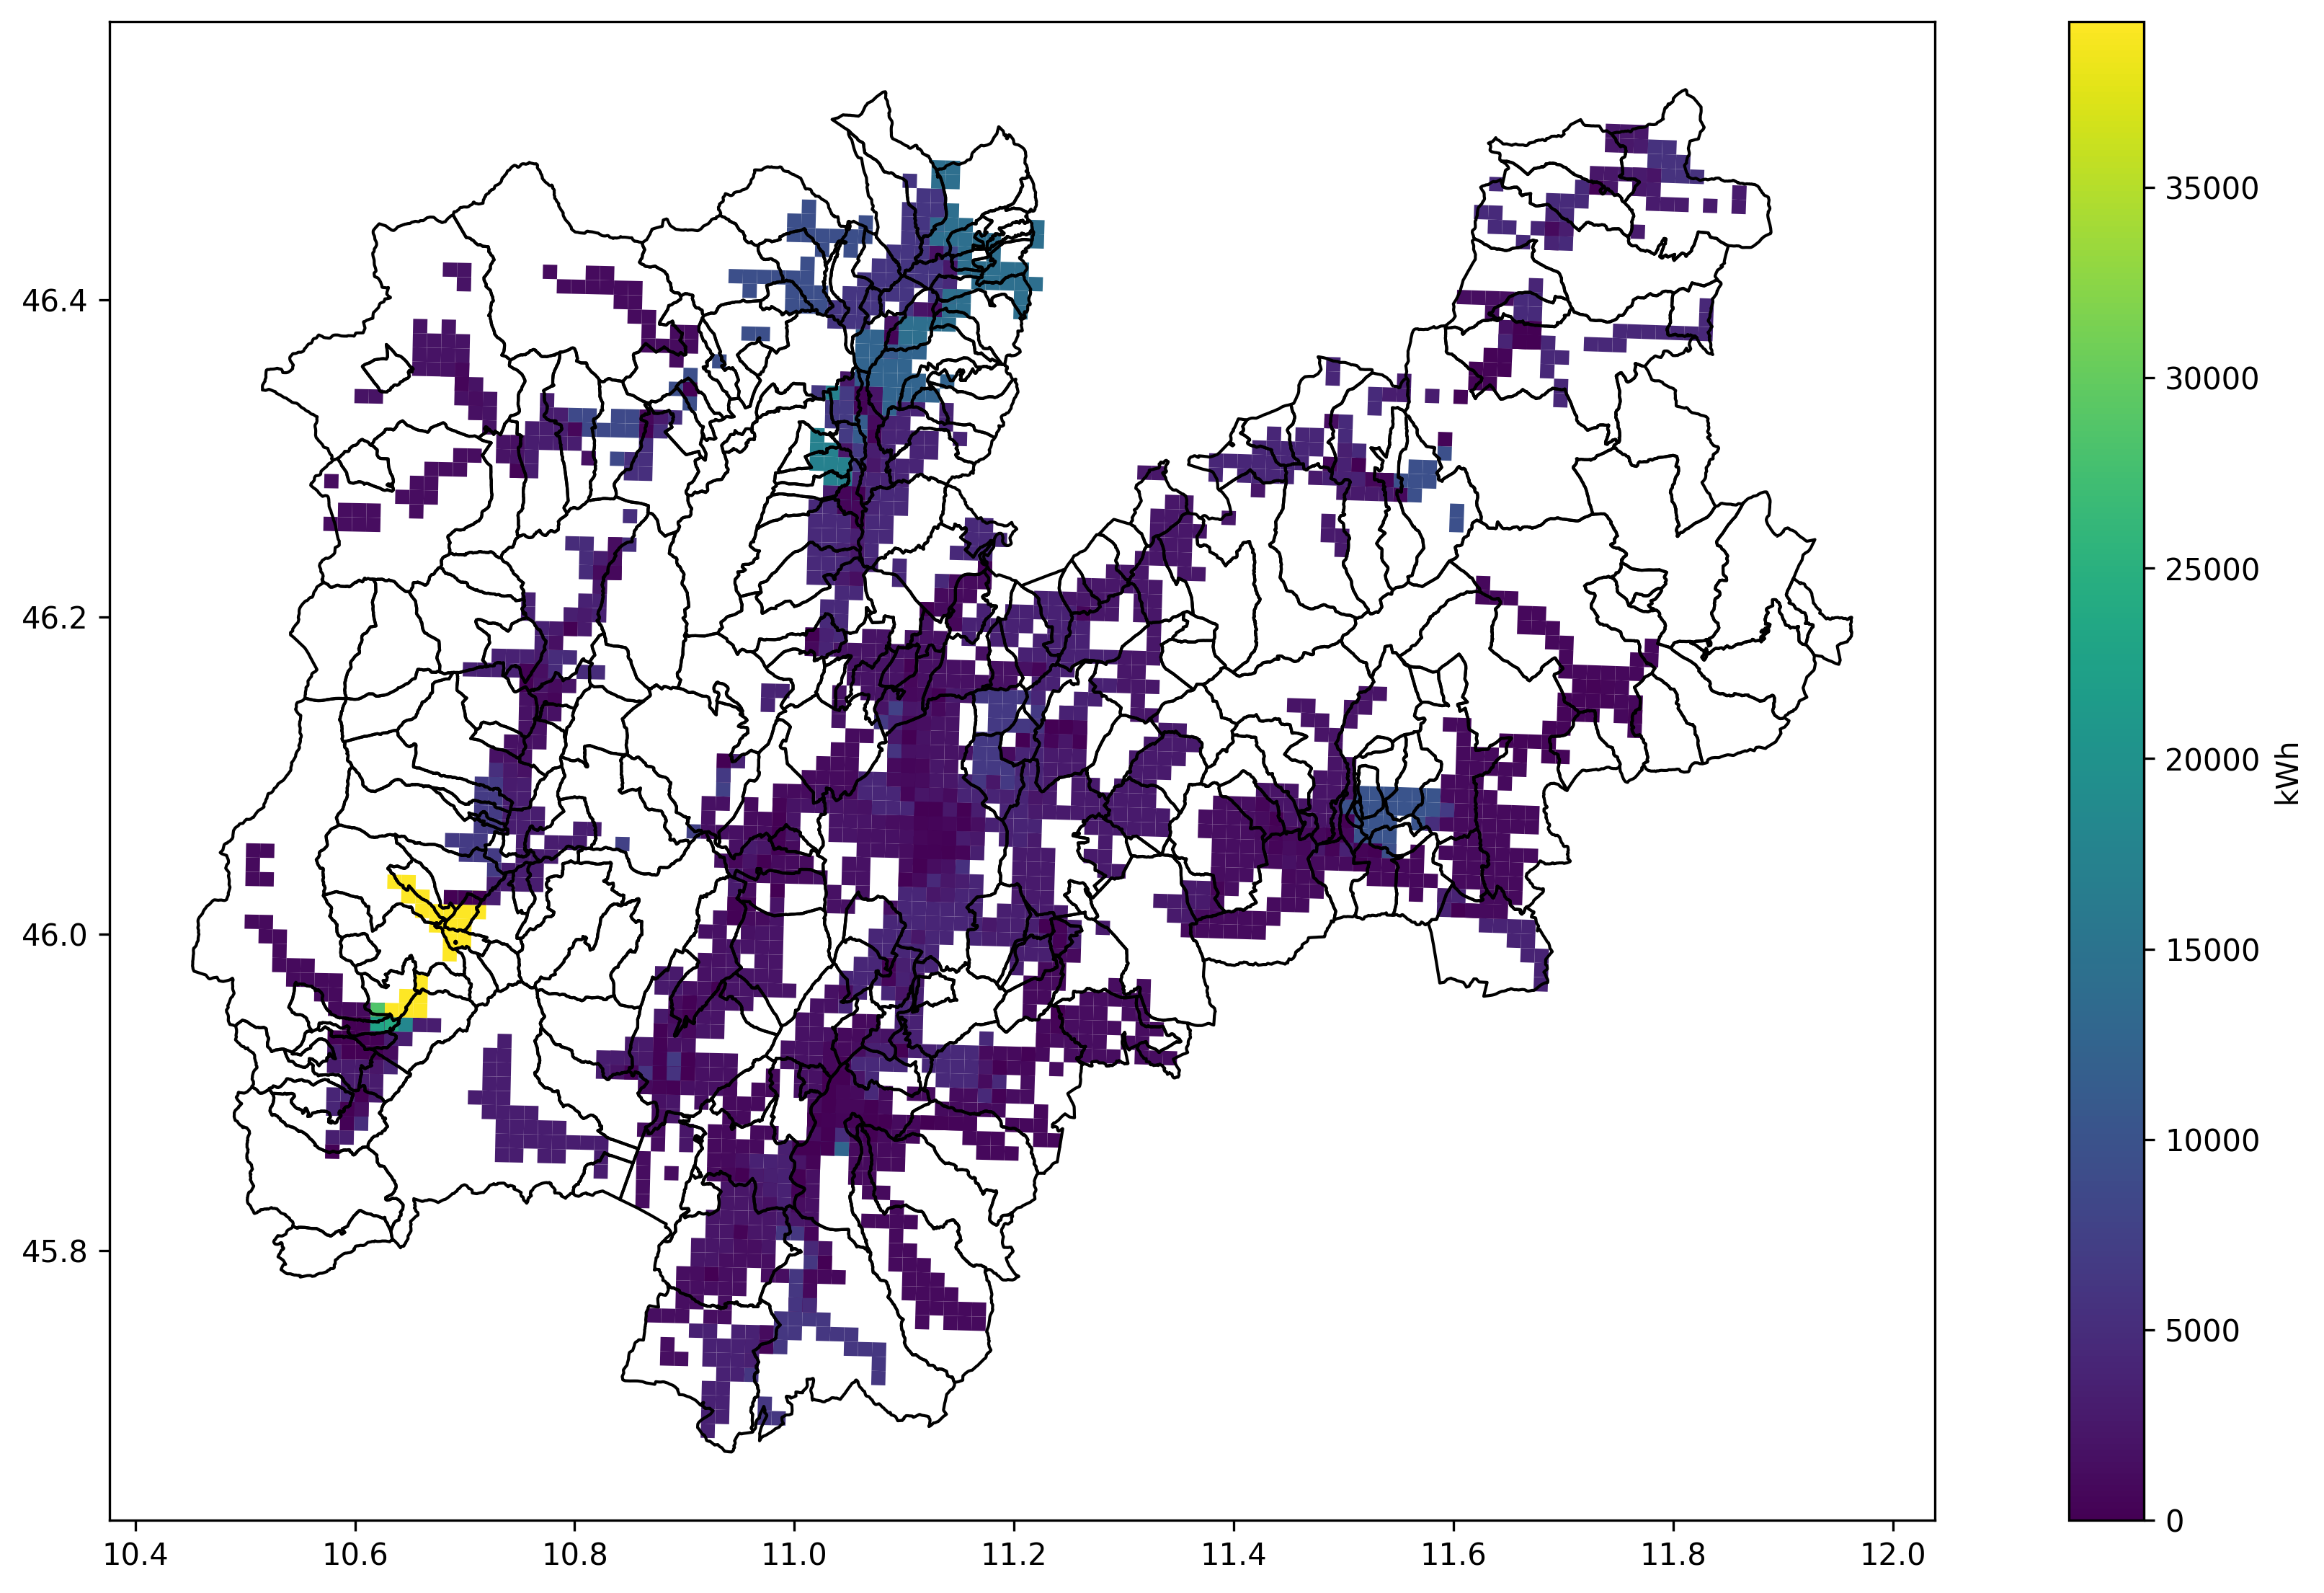

In [115]:
# Seleziono la variazione massima per ogni linea
temp_df = var_day_df.loc[var_day_df.groupby('LINESET')['VAR_POW'].idxmax()].reset_index(drop=True)
temp_df = temp_df[["LINESET",'VAR_POW']]

# uniamo ai dati delle linee e facciamo una media ponderata sulle ubicazioni
temp_df = pd.merge(temp_df,lin_df,on="LINESET")
temp_df["TOT_UBI"] = temp_df.groupby("SQUAREID")["NR_UBI"].transform("sum")
temp_df["VAR_POW_W"] = temp_df["VAR_POW"] * temp_df["NR_UBI"] / temp_df["TOT_UBI"]

# trasformiamo il dataframe in un geodataframe
temp_df = gp.GeoDataFrame(temp_df)


var_day_gdf = pd.merge(tn_grid_gdf,temp_df,left_on="cellId",right_on="SQUAREID").rename(columns={"cellId":"SQUAREID"})


# creiamo la figura e gli assi
fig, ax = plt.subplots(figsize=(16,9), dpi=300)  # dpi aumentato per maggiore risoluzione

# # creiamo la color shape
# norm = TwoSlopeNorm(vmin=var_day_gdf['VAR_POW_W'].min(), 
#                     vcenter=var_day_gdf['VAR_POW_W'].mean(), 
#                     vmax=var_day_gdf['VAR_POW_W'].max())

# plot delle variazioni
var_day_gdf.plot(column='VAR_POW_W', ax=ax, legend=True, legend_kwds={'label': "kWh", 'orientation': "vertical"}) #, norm=norm

# plot della mappa
adm_reg_gdf.plot(ax=ax, color='none', edgecolor='black')
plt.show()

Quello che notiamo è ...  
Notiamo, anche graficamente, come per più della metà delle zone, la massima variazione non supera i 10000kWh

Ora ripetiamo lo stesso procedimento per variazioni nell'arco del mese

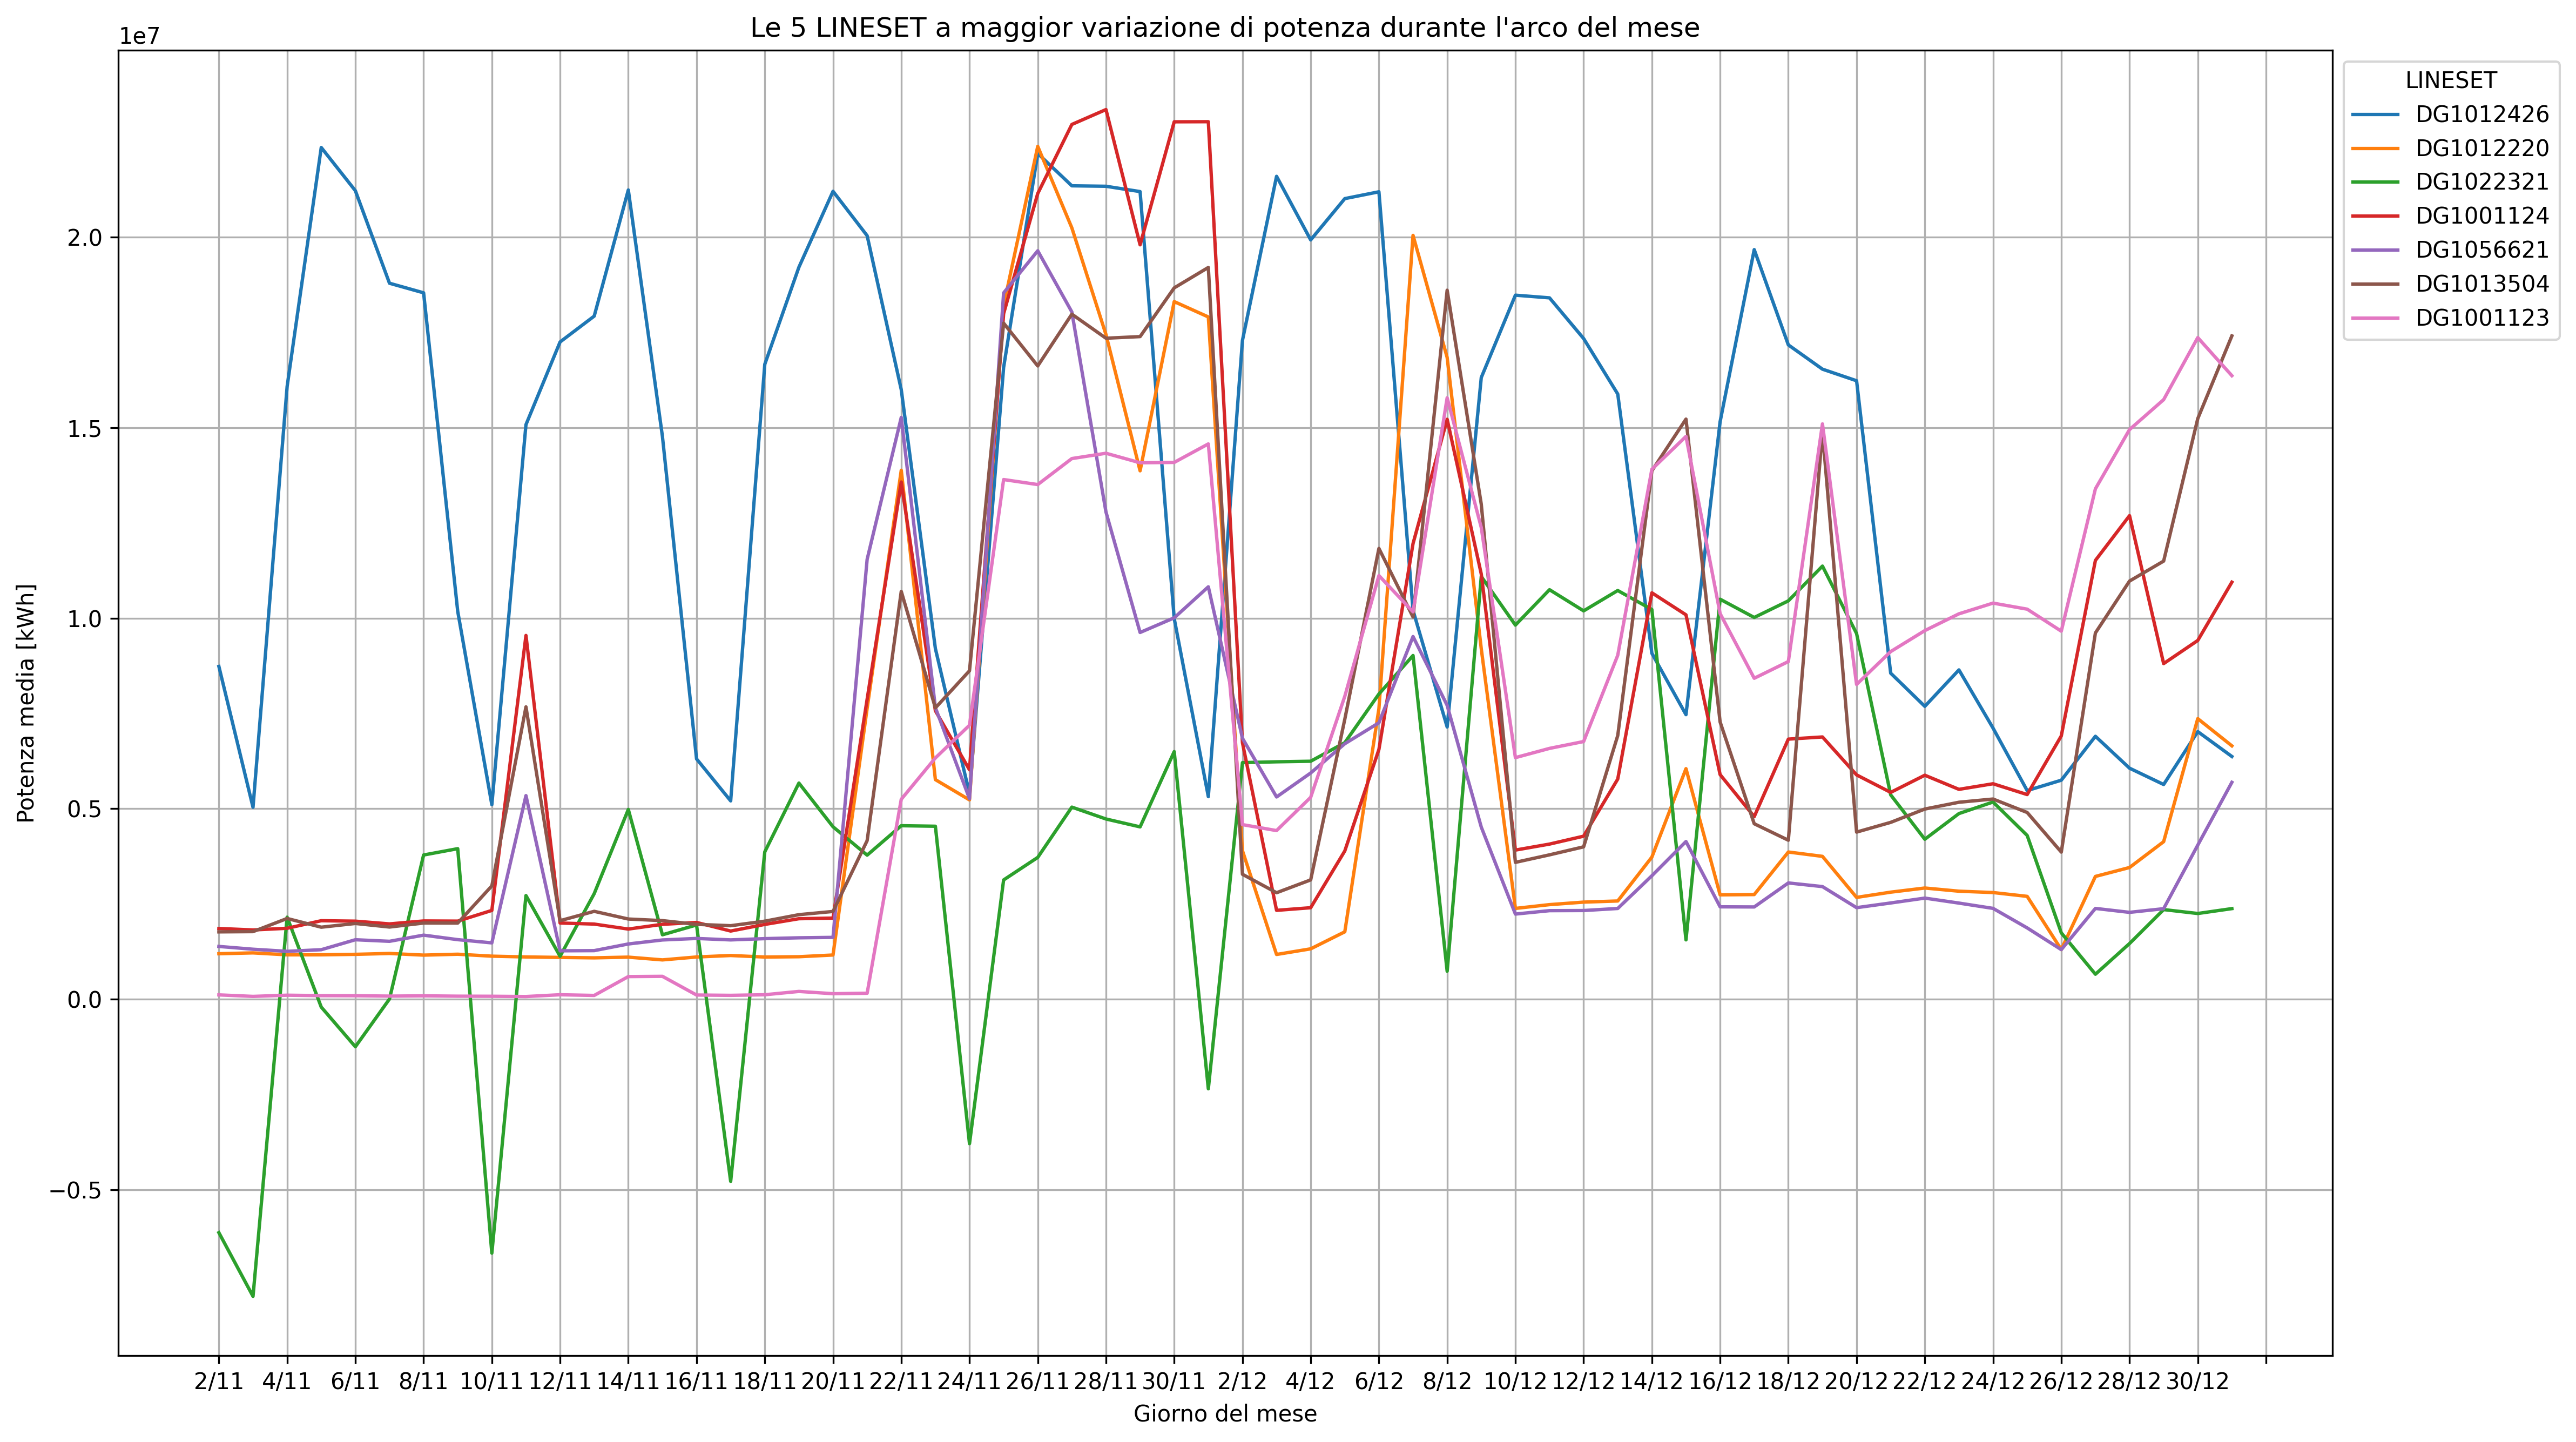

In [128]:
# Creiamo una colonna day_month combinata per plottare
var_mon_df = var_mon_df.sort_values(by=['MONTH', 'DAY'])
var_mon_df['DAY_MONTH'] = var_mon_df['DAY'].astype(str) + "/" + var_mon_df['MONTH'].astype(str)

# Creiamo la figura
fig_day = plt.figure(figsize=(16, 9),dpi=300)

# Loop attraverso i LINESET dove la variazione di potenza supera i 12000 kWh (così preso in modo da avere solo le 5 linee a variazione magiore)
# e plottiamo POWER in funzione di DAY e MONTH
for lineset in var_mon_df['LINESET'][var_mon_df['VAR_POW']>1.5e7].unique(): 
    subset = var_mon_df[var_mon_df['LINESET'] == lineset]
    plt.plot(subset['DAY_MONTH'], subset['POWER'], label=lineset)

# aggiungo le label e il titolo
plt.xlabel('Giorno del mese')
plt.ylabel('Potenza media [kWh]')
plt.title('Le 5 LINESET a maggior variazione di potenza durante l\'arco del mese')

# cambio xticks in modo da mostrare una tacca ogni 2 ore e aggiungo griglia
plt.xticks(np.arange(0,61,step=2))
plt.grid()

# legenda per le diverse LINESET
plt.legend(title='LINESET', bbox_to_anchor=(1, 1), loc='upper left')

# mostriamo il grafico
plt.tight_layout()
plt.show()


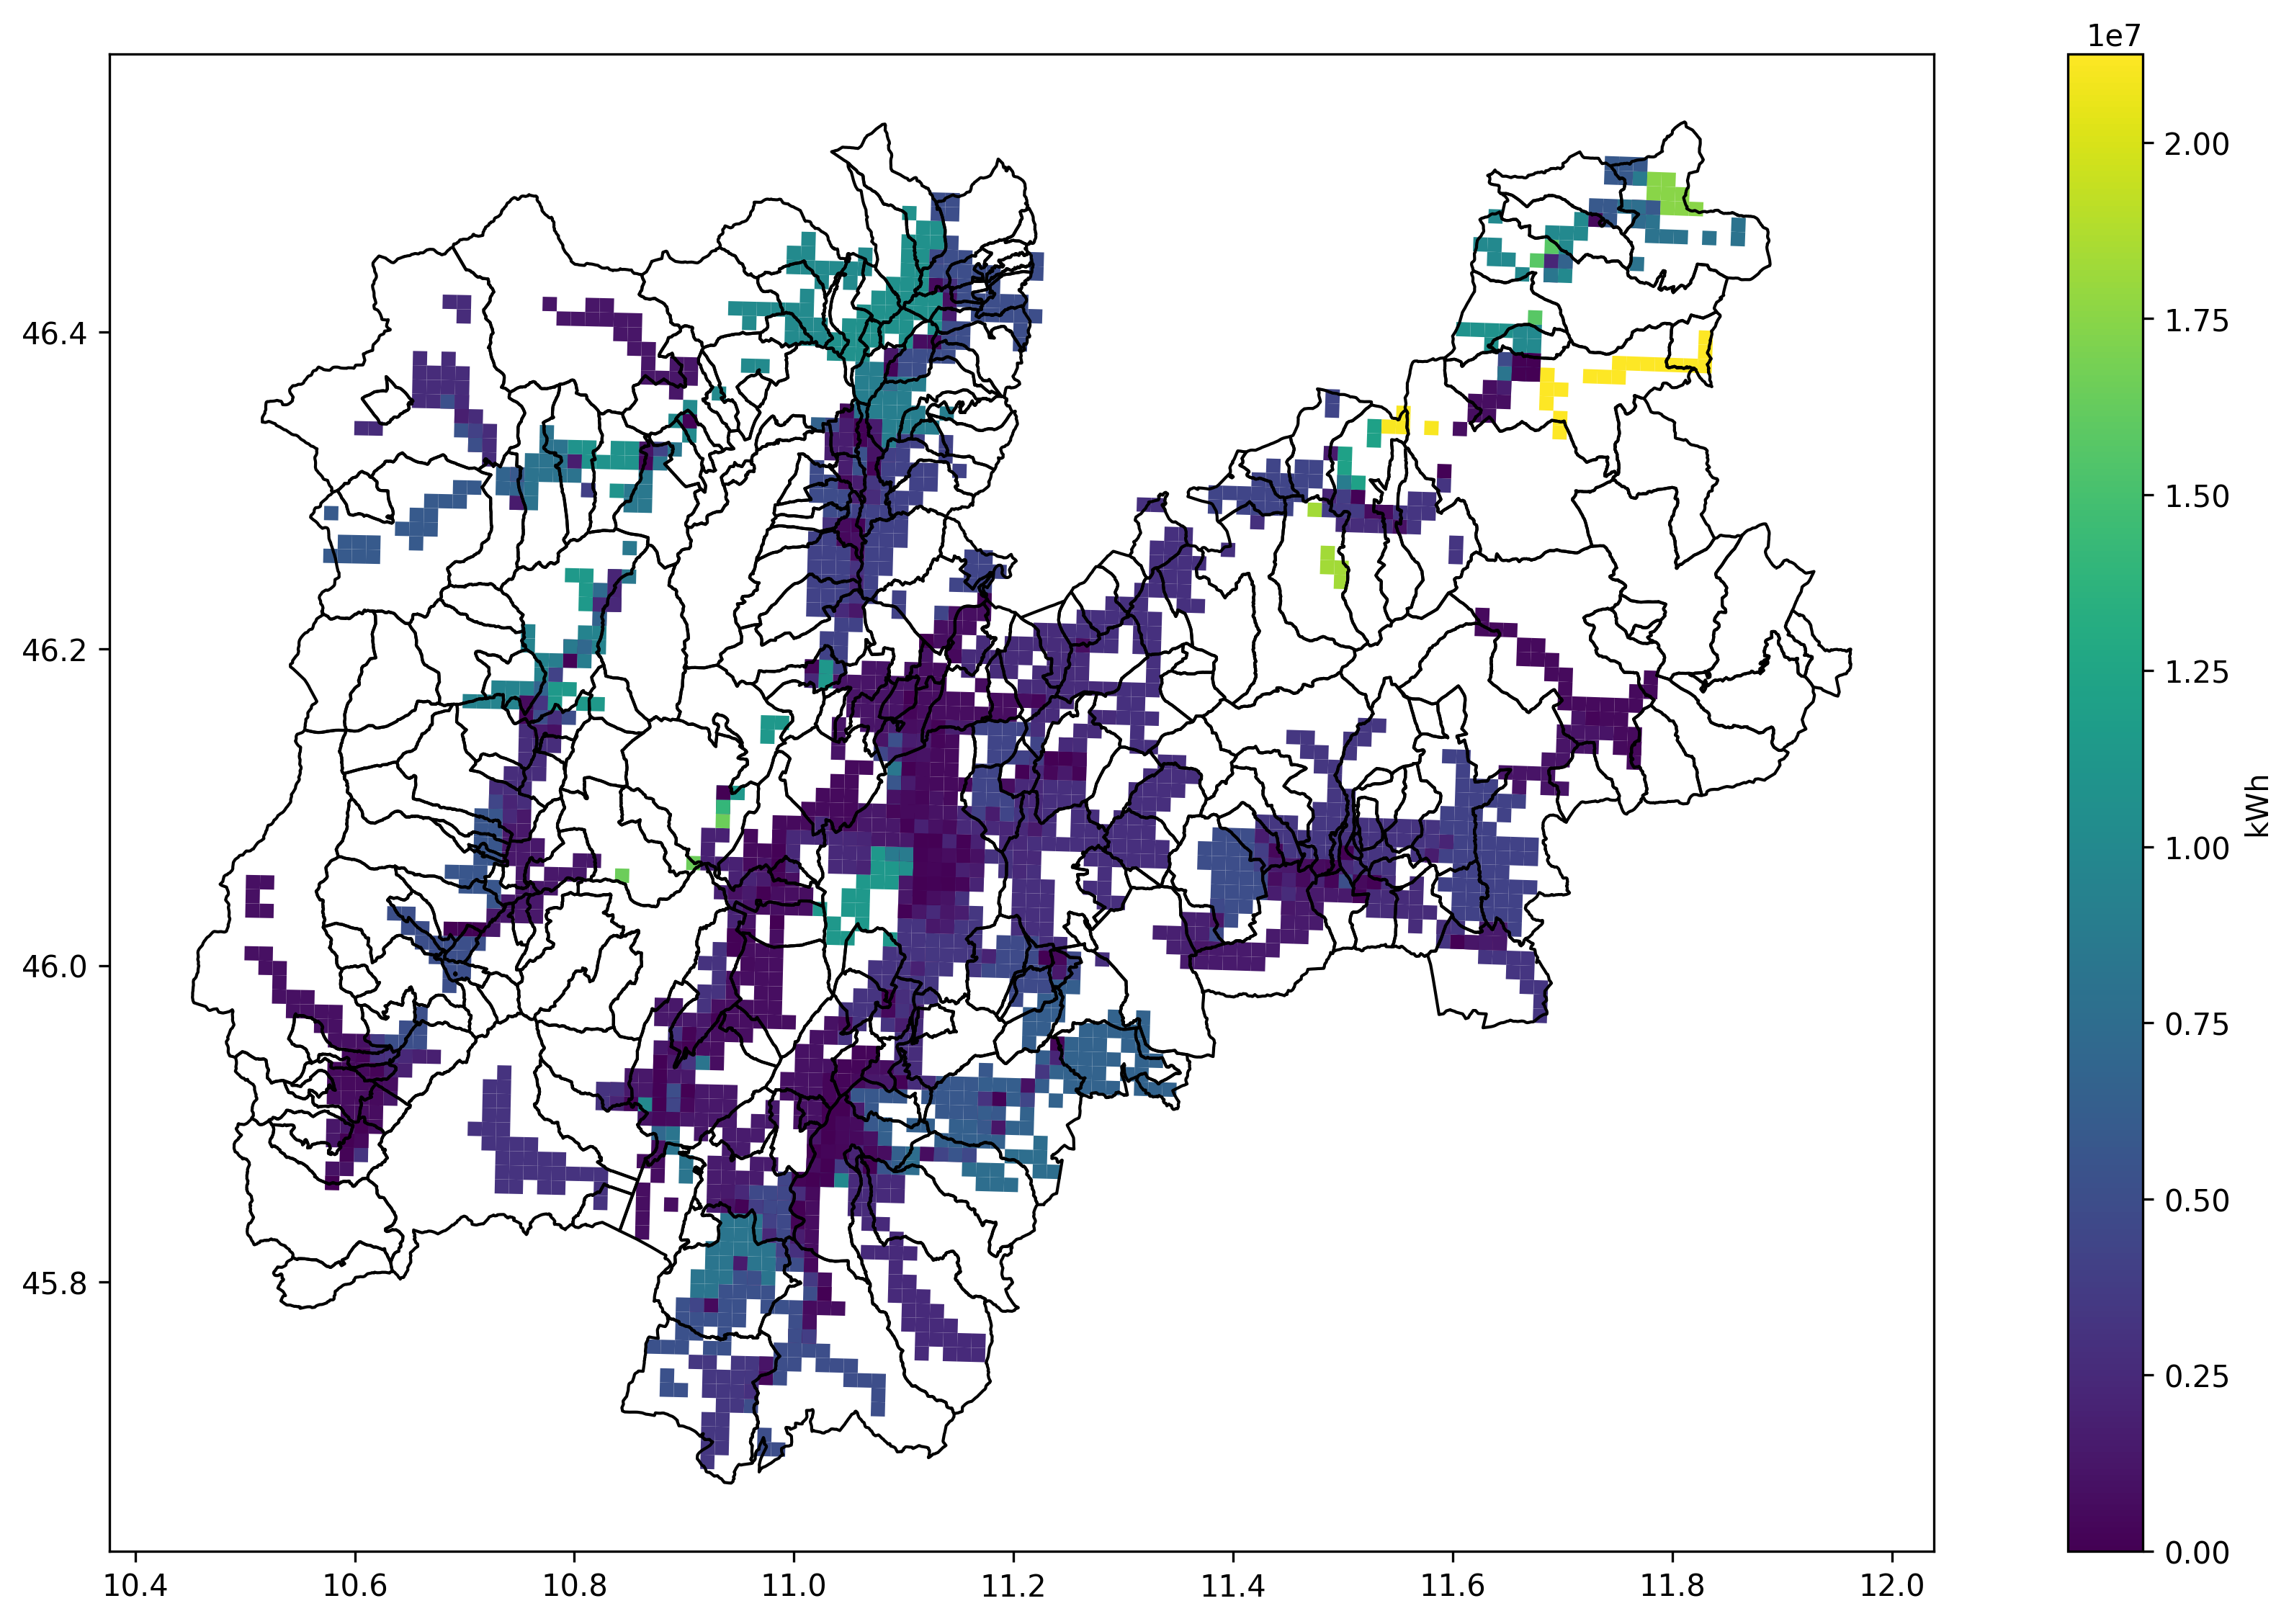

In [117]:
# Seleziono la variazione massima per ogni linea
temp_df = var_mon_df.loc[var_mon_df.groupby('LINESET')['VAR_POW'].idxmax()].reset_index(drop=True)
temp_df = temp_df[["LINESET",'VAR_POW']]

# uniamo ai dati delle linee e facciamo una media ponderata sulle ubicazioni
temp_df = pd.merge(temp_df,lin_df,on="LINESET")
temp_df["TOT_UBI"] = temp_df.groupby("SQUAREID")["NR_UBI"].transform("sum")
temp_df["VAR_POW_W"] = temp_df["VAR_POW"] * temp_df["NR_UBI"] / temp_df["TOT_UBI"]

# trasformiamo il dataframe in un geodataframe
temp_df = gp.GeoDataFrame(temp_df)


var_mon_gdf = pd.merge(tn_grid_gdf,temp_df,left_on="cellId",right_on="SQUAREID").rename(columns={"cellId":"SQUAREID"})
del(temp_df)

# creiamo la figura e gli assi
fig, ax = plt.subplots(figsize=(16,9), dpi=300)  # dpi aumentato per maggiore risoluzione


# plot delle variazioni
var_mon_gdf.plot(column='VAR_POW_W', ax=ax, legend=True, legend_kwds={'label': "kWh", 'orientation': "vertical"})

# plot della mappa
adm_reg_gdf.plot(ax=ax, color='none', edgecolor='black')
plt.show()

Cancelliamo qualche vairabile che non ci serve più per pulizia:

In [118]:
del(ax,fig,fig_day,lineset,norm,subset)

NameError: name 'norm' is not defined

---

## Dati Meteo
Andiamo ora a visualizzare i dati meteo e organizziamoli in un dataframe che saranno poi utili in fase ti classificazione e regressione.

### Precipitazioni
Per prima cosa andiamo a creare e visualizzare il dataframe con le precipitazioni:  

In [108]:
# Importiamo il file csv
tags = ["DATE", "SQUAREID", "RAIN"]
precip_df = pd.read_csv(file_path_raw + 'precipitation-trentino.csv', names=tags)
del(tags)


Aggiustiamo la colonna **DATE** similmente a come già fatto in precedenza per `set_df`

In [109]:
precip_df["DATE"] = pd.to_datetime(precip_df["DATE"], format="%Y%m%d%H%M")
precip_df["MONTH"] = pd.to_datetime(precip_df["DATE"]).dt.month
precip_df["DAY"] = pd.to_datetime(precip_df["DATE"]).dt.day
precip_df["MINUTE"] = pd.to_datetime(precip_df["DATE"]).dt.hour * 60 + pd.to_datetime(precip_df["DATE"]).dt.minute
precip_df["WEEK_DAY"] = pd.to_datetime(precip_df["DATE"]).dt.day_of_week

# ordiniamoli in base alla data
precip_df = precip_df.sort_values(by='DATE')
precip_df = precip_df.reset_index()
del precip_df["index"]

precip_df

DATE  SQUAREID  RAIN  MONTH  DAY  MINUTE  WEEK_DAY
0       2013-11-01 00:00:00      2383     1     11    1       0         4
1       2013-11-01 00:00:00      5429     2     11    1       0         4
2       2013-11-01 00:00:00      5205     1     11    1       0         4
3       2013-11-01 00:00:00      6754     1     11    1       0         4
4       2013-11-01 00:00:00      7436     1     11    1       0         4
...                     ...       ...   ...    ...  ...     ...       ...
3489412 2013-12-26 21:10:00      5193     1     12   26    1270         3
3489413 2013-12-26 21:10:00      4967     1     12   26    1270         3
3489414 2013-12-26 21:10:00      4612     1     12   26    1270         3
3489415 2013-12-26 21:10:00      9697     1     12   26    1270         3
3489416 2013-12-26 21:10:00      6016     1     12   26    1270         3

[3489417 rows x 7 columns]

In [110]:
i = 2307596
precip_df[i:i+4]

DATE  SQUAREID  RAIN  MONTH  DAY  MINUTE  WEEK_DAY
2307596 2013-11-30 01:40:00      9582     1     11   30     100         5
2307597 2013-11-30 01:40:00      7225     1     11   30     100         5
2307598 2013-12-02 00:50:00      9033     1     12    2      50         0
2307599 2013-12-02 00:50:00      9866     1     12    2      50         0

Si può vedere che per alcuni orari mancano dei dati, questo è perché...

Aggiungiamo anche il file `precipitation-trentino-data-availability.csv` così da avere dei valori `true` e `false` se i dati sono presenti o mancanti.

In [111]:
# Importiamo il file csv
tags = ["DATE", "IS_AVAILABLE"]
precip_avail_df = pd.read_csv(file_path_raw + 'precipitation-trentino-data-availability.csv', names=tags)
del(tags)

# Aggiustiamo la data
precip_avail_df["DATE"] = pd.to_datetime(precip_avail_df["DATE"], format="%Y%m%d%H%M")

precip_avail_df

DATE  IS_AVAILABLE
0    2013-11-01 00:00:00          True
1    2013-11-01 00:10:00          True
2    2013-11-01 00:20:00          True
3    2013-11-01 00:30:00          True
4    2013-11-01 00:40:00          True
...                  ...           ...
8779 2013-12-31 23:10:00         False
8780 2013-12-31 23:20:00         False
8781 2013-12-31 23:30:00         False
8782 2013-12-31 23:40:00         False
8783 2013-12-31 23:50:00         False

[8784 rows x 2 columns]

Ora uniamo i due dataframe così da avere un quadro completo  
Inoltre gestiamo i NaN nelle colonne SQUAREID e RAIN, sostituiamoli con degli zeri

In [112]:
precip_df = pd.merge(precip_df, precip_avail_df,on="DATE", how="right")

precip_df["MONTH"] = pd.to_datetime(precip_df["DATE"]).dt.month
precip_df["DAY"] = pd.to_datetime(precip_df["DATE"]).dt.day
precip_df["MINUTE"] = pd.to_datetime(precip_df["DATE"]).dt.hour * 60 + pd.to_datetime(precip_df["DATE"]).dt.minute
precip_df["WEEK_DAY"] = pd.to_datetime(precip_df["DATE"]).dt.day_of_week

# ordiniamoli in base alla data
precip_df = precip_df.sort_values(by='DATE')
precip_df = precip_df.reset_index()
del precip_df["index"]

# gestiamo i NaN nelle colonne SQUAREID e RAIN, sostituiamoli con uno 0
precip_df['SQUAREID'] = precip_df['SQUAREID'].fillna(0).astype(np.int64)
precip_df['RAIN'] = precip_df['RAIN'].fillna(0).astype(np.int64)


precip_df

DATE  SQUAREID  RAIN  MONTH  DAY  MINUTE  WEEK_DAY  \
0       2013-11-01 00:00:00      2383     1     11    1       0         4   
1       2013-11-01 00:00:00      7930     1     11    1       0         4   
2       2013-11-01 00:00:00      7559     1     11    1       0         4   
3       2013-11-01 00:00:00      9815     2     11    1       0         4   
4       2013-11-01 00:00:00      6140     1     11    1       0         4   
...                     ...       ...   ...    ...  ...     ...       ...   
3490952 2013-12-31 23:10:00         0     0     12   31    1390         1   
3490953 2013-12-31 23:20:00         0     0     12   31    1400         1   
3490954 2013-12-31 23:30:00         0     0     12   31    1410         1   
3490955 2013-12-31 23:40:00         0     0     12   31    1420         1   
3490956 2013-12-31 23:50:00         0     0     12   31    1430         1   

         IS_AVAILABLE  
0                True  
1                True  
2                True  
3                True  
4                True  
...               ...  
3490952         False  
3490953         False  
3490954         False  
3490955         False  
3490956         False  

[3490957 rows x 8 columns]